# Setup

In [83]:
import ugradio
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import lstsq, inv, norm
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from scipy.stats import norm, linregress
from scipy.optimize import curve_fit, least_squares
from scipy.signal import find_peaks, stft
from scipy.special import j1
from uncertainties import ufloat
from dataclasses import dataclass
from typing import Dict, Optional, Tuple
import os
import glob
import time
from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [76]:
# Consistent Plot Params
titleSize = 15
axisSize = 15
legendSize = 13
graphSizeSingle = (8, 6)
graphSizeDouble = (15, 6)
graphSizeHorizontal = (20, 6)

# Data Extraction & Cleansing

In [84]:
def extractSdrCalData(sdr_0_paths, sdr_0_cal_paths, sdr_1_paths, sdr_1_cal_paths, normalize=True, pickling=False):
    prefix = "ugastro\\Lab4Data\\"
    sdr_data, cal_data = [[], []], [[], []]
    if normalize:
        for path_0, path_1 in zip(sdr_0_paths, sdr_1_paths):
            sdr_data[0].append(subtractMean(np.load(prefix+path_0, allow_pickle=pickling)))
            sdr_data[1].append(subtractMean(np.load(prefix+path_1, allow_pickle=pickling)))

        for path_0, path_1 in zip(sdr_0_cal_paths, sdr_1_cal_paths):
            cal_data[0].append(subtractMean(np.load(prefix+path_0, allow_pickle=pickling)))
            cal_data[1].append(subtractMean(np.load(prefix+path_1, allow_pickle=pickling)))
    else:
        for path_0, path_1 in zip(sdr_0_paths, sdr_1_paths):
            sdr_data[0].append(np.load(prefix+path_0, allow_pickle=pickling))
            sdr_data[1].append(np.load(prefix+path_1, allow_pickle=pickling))

        for path_0, path_1 in zip(sdr_0_cal_paths, sdr_1_cal_paths):
            cal_data[0].append(np.load(prefix+path_0, allow_pickle=pickling))
            cal_data[1].append(np.load(prefix+path_1, allow_pickle=pickling))
    return sdr_data, cal_data

def extractSdrData(sdr_0_paths, sdr_1_paths, normalize=False, pickling=False):
    prefix = "ugastro\\Lab4Data\\"
    sdr_data = [[], []]
    if normalize:
        for path_0, path_1 in zip(sdr_0_paths, sdr_1_paths):
            sdr_data[0].append(subtractMean(np.load(prefix+path_0, allow_pickle=pickling)))
            sdr_data[1].append(subtractMean(np.load(prefix+path_1, allow_pickle=pickling)))
    else:
        for path_0, path_1 in zip(sdr_0_paths, sdr_1_paths):
            sdr_data[0].append(np.load(prefix+path_0, allow_pickle=pickling))
            sdr_data[1].append(np.load(prefix+path_1, allow_pickle=pickling))
    return sdr_data

def subtractMean(data):
    return data - np.mean(data)

In [85]:
@dataclass
class PointData:
    id: int
    l: float
    b: float
    ra: float
    dec: float
    LSB: Optional[np.ndarray] = None
    USB: Optional[np.ndarray] = None
    is_calibration: bool = False
    timestamp: str = ""

def extractSdrPoints(base_path, normalize=False, correction="") -> Dict[int, Dict[int, PointData]]:
    # Dictionary of two SDRs (device_index 0 & 1)
    data = {
        0: {"normal": [], "calibration": []},
        1: {"normal": [], "calibration": []}
    }

    prefix = "ugastro\\Lab4Data\\"
    for sdr_index in [0, 1]:
        pol_folder = os.path.join(prefix+base_path, f"pol{sdr_index}")
        if not os.path.isdir(pol_folder):
            print(f"Warning: Folder {pol_folder} not found.")
            continue

        for fname in os.listdir(pol_folder):
            if fname.endswith(".npz") and fname.startswith("obs_"):
                # Parse the filename: obs_{point_id}_{mode}.npz
                parts = fname.replace(correction+".npz", "").split("_")
                try:
                    point_id = int(parts[1])
                    mode = "_".join(parts[2:])  # "LSB" or "USB"
                except (IndexError, ValueError):
                    print(f"Skipping unrecognized file: {fname}")
                    continue

                file_path = os.path.join(pol_folder, fname)
                try:
                    with np.load(file_path) as npzfile:    
                        spectrum = npzfile['spectrum']
                        if normalize:
                            spectrum = spectrum / np.max(spectrum)

                        point = PointData(
                            id=point_id,
                            l=npzfile["gal_l"].item(),
                            b=npzfile["gal_b"].item(),
                            ra=npzfile["ra"].item(),
                            dec=npzfile["dec"].item(),
                            is_calibration=bool(npzfile["is_calibration"].item()),
                            timestamp=str(npzfile["timestamp"])
                        )

                        if mode == "LSB":
                            point.LSB = spectrum
                            point.USB = None
                            point.is_calibration = False
                        elif mode == "USB":
                            point.USB = spectrum
                            point.LSB = None
                            point.is_calibration = False
                        elif mode == "cal_on":
                            point.USB = spectrum
                            point.is_calibration = True
                        else:
                            print(f"Unknown mode: {mode} in file {fname}")

                        if mode not in ("USB", "LSB"):
                            data[sdr_index]["calibration"].append(point)
                        else:
                            data[sdr_index]["normal"].append(point)
                            
                except Exception as e:
                    print(f"{file_path} Error: {e}")
                    continue
    return data

folder_path = "4_25_1"
correction = ".npy"
data_4_25 = extractSdrPoints(folder_path, correction=correction)

In [86]:
print(len(data_4_25[0]['normal']))
print(len(data_4_25[0]["calibration"]))

30
12


In [97]:
LO_USB = 1420e6
LO_LSB = 1420.81150357e6
B = 12e6
SAMPLE_RATE = 2.2e6
WINDOW = 2048
bounds=(5, -5)

# Power Spectrum Plotting

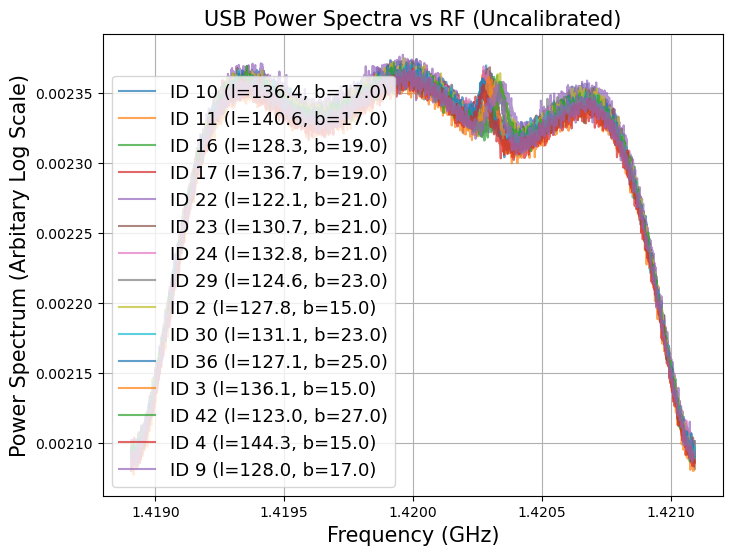

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2048 but corresponding boolean dimension is 2038

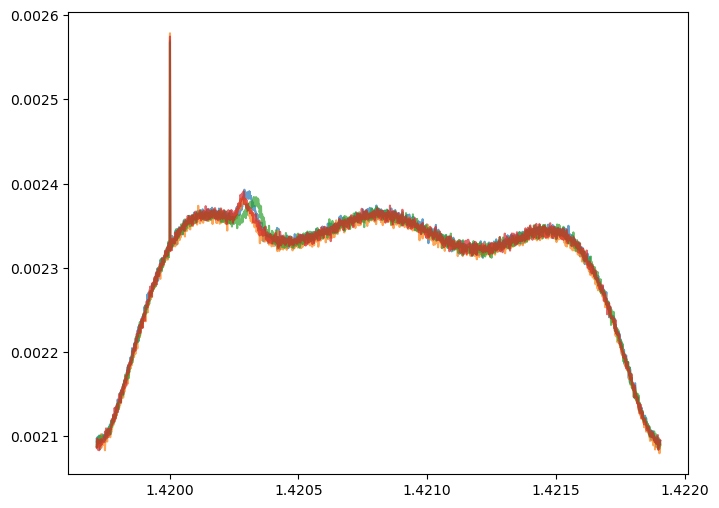

In [114]:
def plot_power_spectra(points, which="USB", LO=LO_USB, spike_mask_range=None, normalize=False, xlim=None, ylim=None, title_extra=""):
    plt.figure(figsize=graphSizeSingle)

    freqs = fftfreq(WINDOW, 1/SAMPLE_RATE) + LO
    freqs = fftshift((freqs))[bounds[0]:bounds[1]]
    #freqs = freqs[bounds[0]:bounds[1]]
    
    for point in points:
        spectrum = getattr(point, which)
        if spectrum is None:
            continue    # Skip

        if spike_mask_range and (point.id in (9, 22)):
            spectrum = mask_and_resample_spike(freqs, spectrum, spike_mask_range)
        spectrum = spectrum - np.mean(spectrum) if normalize else spectrum
        spectrum = fftshift(np.log(spectrum[bounds[0]:bounds[1]]))
        #spectrum = np.log(spectrum[bounds[0]:bounds[1]])
        label = f"ID {point.id} (l={point.l:.1f}, b={point.b:.1f})"
        plt.plot(freqs / 1e9, spectrum / 4e3, label=label, alpha=0.7)

    plt.xlabel("Frequency (GHz)", fontsize=axisSize)
    plt.ylabel("Power Spectrum (Arbitary Log Scale)", fontsize=axisSize)
    #plt.yscale("log")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    title_label = "(Normalized)" if normalize else "(Uncalibrated)"
    plt.title(f"{which} Power Spectra vs RF {title_label}", size=titleSize)
    plt.grid()
    plt.show()

def mask_and_resample_spike(freqs, spectrum, spike_range):
    low, high = spike_range
    center_freq = (low + high) / 2
    
    mask_left = (freqs >= low) & (freqs < center_freq)
    mask_right = (freqs >= center_freq) & (freqs <= high)

    # Find nearest neighbors outside the mask
    idx_left = np.where(freqs < low)[0]
    idx_right = np.where(freqs > high)[0]

    if len(idx_left) > 0:
        val_left = spectrum[idx_left[-1]]  # last good point before spike
    else:
        val_left = spectrum[0]

    if len(idx_right) > 0:
        val_right = spectrum[idx_right[0]]  # first good point after spike
    else:
        val_right = spectrum[-1]

    cleaned = np.copy(spectrum)
    cleaned[mask_left] = val_left
    cleaned[mask_right] = val_right

    return cleaned

mask = (1.41995e9, 1.42005e9)
plot_power_spectra(data_4_25[0]["normal"], which="USB", LO=LO_USB)
plot_power_spectra(data_4_25[0]["normal"], which="LSB", LO=LO_LSB, spike_mask_range=mask)
plot_power_spectra(data_4_25[0]["calibration"], which="USB", LO=LO_USB)



15
{(136.371, 17): {'online': array([3350627.12302326,   12616.16915229,   12610.62766242, ...,
         13485.88684961,   12967.74247539,   13052.17036784]), 'offline': array([3352761.60883721,   12671.10692465,   12827.71697943, ...,
         12616.12587912,   12780.24600591,   12569.52944795]), 'line_shape': array([0.99936336, 0.99566433, 0.98307654, ..., 1.06894042, 1.0146708 ,
       1.03839769])}, (140.554, 17): {'online': array([3349976.90906977,   12569.55760866,   12372.75629055, ...,
         13087.65548461,   12932.67123937,   12663.85663772]), 'offline': array([3348589.19      ,   12773.13409305,   12587.5253081 , ...,
         12343.59226383,   12696.75975557,   12409.75335653]), 'line_shape': array([1.00041442, 0.98406214, 0.98293795, ..., 1.06027931, 1.01858045,
       1.02047609])}, (128.268, 19): {'online': array([3356967.50813953,   12721.70043454,   12747.06366436, ...,
         13686.05803897,   12698.6648751 ,   13007.35405057]), 'offline': array([3352513.69976744,

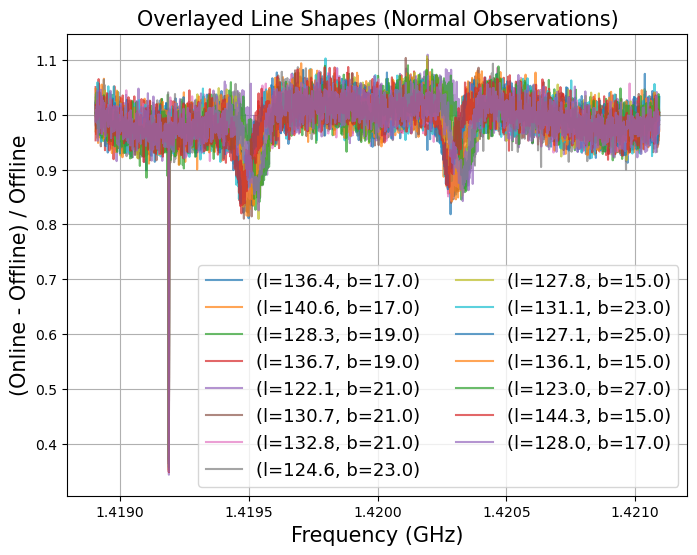

In [82]:
def onlineOfflineSpectra(points, normalize=False) -> Dict[Tuple[float, float], Dict[str, np.ndarray]]:
    temp_storage: Dict[Tuple[float, float], Dict[str, np.ndarray]] = {}

    for point in points:
        key = (round(point.l, 3), round(point.b, 3))
        if key not in temp_storage:
            temp_storage[key] = {"USB": None, "LSB": None}

        if point.USB is not None:
            temp_storage[key]["USB"] = point.USB
        if point.LSB is not None:
            temp_storage[key]["LSB"] = point.LSB

    result: Dict[Tuple[float, float], Dict[str, np.ndarray]] = {}

    for (l, b), spectra in temp_storage.items():
        usb = spectra["USB"]
        lsb = spectra["LSB"]

        if usb is None or lsb is None:
            # skip incomplete points
            continue

        if normalize:
            usb = usb / np.max(usb)
            lsb = lsb / np.max(lsb)

        mid = len(usb) // 2
        online, offline = np.zeros(len(usb)), np.zeros(len(usb))
        online[:mid], offline[:mid] = lsb[:mid], usb[:mid]
        online[mid:], offline[mid:] = usb[mid:], lsb[mid:]

        line_shape = online / offline

        result[(l, b)] = {
            "online": online,
            "offline": offline,
            "line_shape": line_shape
        }

    return result

def plot_lineshapes(online_offline_data, xlim=None, ylim=None, title_extra=""):
    plt.figure(figsize=graphSizeSingle)
    freqs = fftfreq(WINDOW, 1/SAMPLE_RATE) + LO_USB
    freqs = fftshift(freqs)[bounds[0]:bounds[1]]

    for (l, b), spectra in online_offline_data.items():
        lineshape = spectra["line_shape"]
        lineshape = fftshift(lineshape[bounds[0]:bounds[1]])

        label = f"(l={l:.1f}, b={b:.1f})"
        plt.plot(freqs / 1e9, lineshape, alpha=0.7, label=label)

    plt.xlabel("Frequency (GHz)", fontsize=axisSize)
    plt.ylabel("(Online - Offline) / Offline", fontsize=axisSize)
    plt.title(f"Overlayed Line Shapes {title_extra}", size=titleSize)
    plt.grid()
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize, ncol=2)  # 2 columns for compactness
    plt.show()

online_offline_data = onlineOfflineSpectra(data_4_25[0]["normal"])
print(len(online_offline_data))
print(online_offline_data)

plot_lineshapes(online_offline_data, title_extra="(Normal Observations)")

## TO DO
- Compute Gain and calibrate spectra
- Low poly fit on calibrated spectra?
- Gaussian fits on Doppler velocity
- Column density and mass calculation
- Map projection plotting